# Values Tutorial
https://symforce.org/tutorials/values_tutorial.html

Values objects are ordered dict-like containers used to store multiple heterogeneous objects, normally for the purpose of function generation.

Typically a Values object will first be created to defines a number of different symbolic inputs (e.g. rotations, translations, scalars, poses, cameras, etc.). Then, a second Values object will be created to describe the objects to be returned from the function, which will be composed of the symbolic elements defined by the input Values object.

In [1]:
# Setup
import symforce

symforce.set_symbolic_api("sympy")
symforce.set_log_level("warning")

import symforce.symbolic as sf
from symforce.values import Values
from symforce.notebook_util import display, display_code, display_code_file

In [2]:
inputs = Values(
    x=sf.Symbol("x"),
    y=sf.Rot2.symbolic("c"),
)
display(inputs)

Values(
  x: x,
  y: <Rot2 <C real=c_re, imag=c_im>>,
)

In [3]:
#The .add() method can add a symbol using its name as the key:
inputs.add(sf.Symbol("foo"))
display(inputs)

Values(
  x: x,
  y: <Rot2 <C real=c_re, imag=c_im>>,
  foo: foo,
)

In [5]:
#Adding sub-values are well encouraged:
x, y = sf.symbols("x y")
expr = x ** 2 + sf.sin(y) / x ** 2
inputs["states"] = Values(p=expr)
display(inputs)

Values(
  x: x,
  y: <Rot2 <C real=c_re, imag=c_im>>,
  foo: foo,
  states:   Values(
    p: x**2 + sin(y)/x**2,
  ),
)

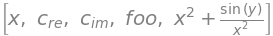

In [6]:
#A Values serializes to a depth-first traversed list. This means it implements StorageOps:
display(inputs.to_storage())

In [7]:
#We can also get a flattened lists of keys and values, with . separation for sub-values:
display(inputs.items_recursive())

[('x', x),
 ('y', <Rot2 <C real=c_re, imag=c_im>>),
 ('foo', foo),
 ('states.p', x**2 + sin(y)/x**2)]

Note that there is a .keys_recursive() and a .values_recursive() which return flattened lists of keys and values respectively:

In [8]:
display(inputs.keys_recursive())
display(inputs.values_recursive())

['x', 'y', 'foo', 'states.p']

[x, <Rot2 <C real=c_re, imag=c_im>>, foo, x**2 + sin(y)/x**2]

To fully reconstruct the types in the Values from the serialized scalars, we need an index that describes which parts of the serialized list correspond to which types. The spec is T.Dict[str, IndexEntry] where IndexEntry has attributes offset, storage_dim, datatype, shape, item_index:

In [9]:
index = inputs.index()
index

OrderedDict([('x',
  IndexEntry(offset=0, storage_dim=1, _module='builtins', _qualname='float', shape=None, item_index=None)),
 ('y',
  IndexEntry(offset=1, storage_dim=2, _module='symforce.geo.rot2', _qualname='Rot2', shape=None, item_index=None)),
 ('foo',
  IndexEntry(offset=3, storage_dim=1, _module='builtins', _qualname='float', shape=None, item_index=None)),
 ('states',
  IndexEntry(offset=4, storage_dim=1, _module='symforce.values.values', _qualname='Values', shape=None, item_index=OrderedDict([('p', IndexEntry(offset=0, storage_dim=1, _module='builtins', _qualname='float', shape=None, item_index=None))])))])

In [10]:
#With a serialized list and an index, we can get the values back:
inputs2 = Values.from_storage_index(inputs.to_storage(), index)
assert inputs == inputs2
display(inputs)

Values(
  x: x,
  y: <Rot2 <C real=c_re, imag=c_im>>,
  foo: foo,
  states:   Values(
    p: x**2 + sin(y)/x**2,
  ),
)

In [11]:
#The item_index is a recursive structure that can contain the index for a sub-values:
item_index = inputs.index()["states"].item_index
assert item_index == inputs["states"].index()

In [12]:
#We can also set sub-values directly with dot notation in the keys. They get split up:
inputs["states.blah"] = 3
display(inputs)

Values(
  x: x,
  y: <Rot2 <C real=c_re, imag=c_im>>,
  foo: foo,
  states:   Values(
    p: x**2 + sin(y)/x**2,
    blah: 3,
  ),
)

The .attr field also allows attribute access rather than key access

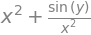

In [13]:
assert inputs["states.p"] is inputs["states"]["p"] is inputs.attr.states.p
display(inputs.attr.states.p)

Finally, SymForce adds the concept of a name scope to namespace symbols. Within a scope block, symbol names get prefixed with the scope name:

In [14]:
with sf.scope("params"):
    s = sf.Symbol("cost")
display(s)

A common use case is to call a function that adds symbols within your own name scope to avoid name collisions. You can also chain name scopes:

In [15]:
v = Values()
v.add(sf.Symbol("x"))
with sf.scope("foo"):
    v.add(sf.Symbol("x"))
    with sf.scope("bar"):
        v.add(sf.Symbol("x"))
display(v)
display(v.attr.foo.bar.x)

Values(
  x: x,
  foo:   Values(
    x: foo.x,
    bar:     Values(
      x: foo.bar.x,
    ),
  ),
)

In [17]:
v = Values()
with v.scope("hello"):
    v["y"] = x ** 2
    v["z"] = sf.Symbol("z")
v

Values(
  hello:   Values(
    y: x**2,
    z: hello.z,
  ),
)

This flexible set of features provided by the Values class allows conveniently building up large expressions, and acts as the interface to code generation.

# Lie Group Operations
One useful feature of Values objects is that element-wise Lie group operations on can be performed on them.

In [19]:
new_lieGroup = Values()
new_lieGroup["scalar"] = sf.Symbol("x")
new_lieGroup["rot3"] = sf.Rot3.symbolic("R")

sub_lieGroup = Values()
sub_lieGroup["pose3"] = sf.Pose3.symbolic("T")
sub_lieGroup["vec"] = sf.V3.symbolic("v")

new_lieGroup["sub_lieGroup"] = sub_lieGroup

display(new_lieGroup)

Values(
  scalar: x,
  rot3: <Rot3 <Q xyzw=[R_x, R_y, R_z, R_w]>>,
  sub_lieGroup:   Values(
    pose3: <Pose3 R=<Rot3 <Q xyzw=[T.R_x, T.R_y, T.R_z, T.R_w]>>, t=(T.t0, T.t1, T.t2)>,
    vec: Matrix([
[v0],
[v1],
[v2]]),
  ),
)

⎡1    0       0      0       0        0         0        0         0      0  0
⎢                                                                             
⎢0  2⋅R_w   2⋅R_z  -2⋅R_y  -2⋅Rₓ      0         0        0         0      0  0
⎢                                                                             
⎢0  -2⋅R_z  2⋅R_w   2⋅Rₓ   -2⋅R_y     0         0        0         0      0  0
⎢                                                                             
⎢0  2⋅R_y   -2⋅Rₓ  2⋅R_w   -2⋅R_z     0         0        0         0      0  0
⎢                                                                             
⎢0    0       0      0       0     2⋅T.R_w   2⋅T.R_z  -2⋅T.R_y  -2⋅T.Rₓ   0  0
⎢                                                                             
⎢0    0       0      0       0     -2⋅T.R_z  2⋅T.R_w   2⋅T.Rₓ   -2⋅T.R_y  0  0
⎢                                                                             
⎢0    0       0      0       0     2⋅T.R_y   -2⋅T.Rₓ

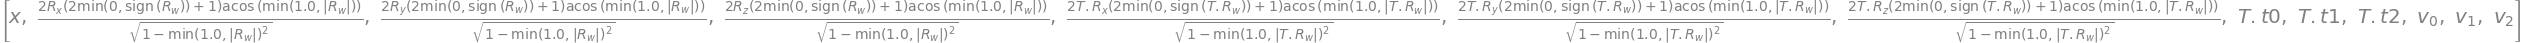

In [26]:
#Importantly, we can compute the jacobian of the storage space of the object with respect to its tangent space:
display(new_lieGroup.to_storage())

display(new_lieGroup.tangent_D_storage())

display(new_lieGroup.to_tangent())


This means that we can use the elements of the object to compute a residual, and then compute the jacobian of such a residual with respect to the tangent space of our values object.

In [35]:
residual = sf.Matrix(6, 1) #define residual be a 6x1 matrix
display(residual)
residual[0:3, 0] = new_lieGroup["rot3"] * new_lieGroup["sub_lieGroup.vec"] #add the first 3 rows of the residual matrix to the first 3 rows of the matrix
residual[3:6, 0] = new_lieGroup["sub_lieGroup.pose3"] * new_lieGroup["sub_lieGroup.vec"] #add the last 3 rows of the residual matrix to the last 3 rows of the matrix
display(residual)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

⎡                ⎛       2        2    ⎞                                      
⎢             v₀⋅⎝- 2⋅R_y  - 2⋅R_z  + 1⎠ + v₁⋅(-2⋅R_w⋅R_z + 2⋅Rₓ⋅R_y) + v₂⋅(2⋅
⎢                                                                             
⎢                                             ⎛      2        2    ⎞          
⎢              v₀⋅(2⋅R_w⋅R_z + 2⋅Rₓ⋅R_y) + v₁⋅⎝- 2⋅Rₓ  - 2⋅R_z  + 1⎠ + v₂⋅(-2⋅
⎢                                                                             
⎢                                                                          ⎛  
⎢              v₀⋅(-2⋅R_w⋅R_y + 2⋅Rₓ⋅R_z) + v₁⋅(2⋅R_w⋅Rₓ + 2⋅R_y⋅R_z) + v₂⋅⎝- 
⎢                                                                             
⎢          ⎛         2          2    ⎞                                        
⎢T.t0 + v₀⋅⎝- 2⋅T.R_y  - 2⋅T.R_z  + 1⎠ + v₁⋅(-2⋅T.R_w⋅T.R_z + 2⋅T.Rₓ⋅T.R_y) + 
⎢                                                                             
⎢                                              ⎛    

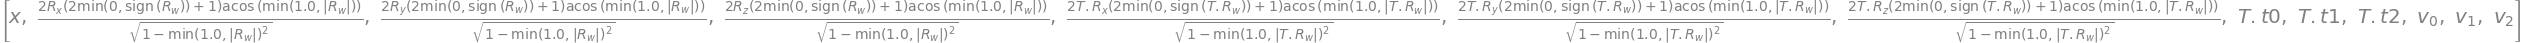

⎡                                                                             
⎢0     v₁⋅(2⋅R_w⋅R_y + 2⋅Rₓ⋅R_z) + v₂⋅(2⋅R_w⋅R_z - 2⋅Rₓ⋅R_y)       v₀⋅(-2⋅R_w⋅
⎢                                                                             
⎢                                   ⎛     2     2      2      2⎞              
⎢0  v₁⋅(-2⋅R_w⋅Rₓ + 2⋅R_y⋅R_z) + v₂⋅⎝- R_w  + Rₓ  - R_y  + R_z ⎠     v₀⋅(2⋅R_w
⎢                                                                             
⎢       ⎛   2     2      2      2⎞                                   ⎛     2  
⎢0   v₁⋅⎝R_w  - Rₓ  - R_y  + R_z ⎠ + v₂⋅(-2⋅R_w⋅Rₓ - 2⋅R_y⋅R_z)   v₀⋅⎝- R_w  +
⎢                                                                             
⎢                                                                             
⎢0                               0                                            
⎢                                                                             
⎢                                                   

In [38]:
residual_D_tangent = residual.jacobian(new_lieGroup)

display(new_lieGroup.to_tangent())
display(residual_D_tangent.shape)
display(residual_D_tangent)